In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_core langchain_community

In [2]:
import sqlite3

#connect to SQLite DB
conn = sqlite3.connect('hotel.db')
cursor = conn.cursor()

# Create the rooms table
cursor.execute('''
CREATE TABLE IF NOT EXISTS rooms (
  room_number INTEGER PRIMARY KEY,
  room_type TEXT NOT NULL,
  price REAL NOT NULL,
  max_capacity INTEGER NOT NULL,
  amenities TEXT
)
''')

# Create the reservations table
cursor.execute('''
CREATE TABLE IF NOT EXISTS reservations (
  reservation_id INTEGER PRIMARY KEY AUTOINCREMENT,
  guest_name TEXT NOT NULL,
  room_number INTEGER NOT NULL,
  start_date DATE NOT NULL,
  end_date DATE NOT NULL,
  FOREIGN KEY (room_number) REFERENCES rooms(room_number)
)
''')


# Example data for rooms
rooms_data = [
  (101, 'Single', 100, 1, 'TV, Wi-Fi'),
  (102, 'Double', 150, 2, 'TV, Wi-Fi, Balcony'),
  (103, 'Suite', 250, 3, 'TV, Wi-Fi, Balcony, Jacuzzi'),
  (104, 'Deluxe', 200, 2, 'TV, Wi-Fi, Mini-bar'),
  (105, 'Family Suite', 300, 4, 'TV, Wi-Fi, Balcony, Kitchenette'),
  (106, 'Executive Suite', 350, 2, 'TV, Wi-Fi, Balcony, Jacuzzi, City View'),
  (107, 'Double', 150, 2, 'TV, Wi-Fi'),
  (108, 'Deluxe', 200, 2, 'TV, Wi-Fi, Balcony, Fireplace')
]

# Insert the data
cursor.executemany('INSERT OR IGNORE INTO rooms VALUES (?, ?, ?, ?, ?)', rooms_data)

reservations_data = [
    ('Alice Smith', 102, '2025-03-15', '2025-03-18'),
    ('Bob Johnson', 105, '2025-04-22', '2025-04-25'),
    ('Charlie Brown', 106, '2025-06-10', '2025-06-12')
]

# Insert the data
cursor.executemany('INSERT INTO reservations (guest_name, room_number, start_date, end_date) VALUES (?, ?, ?, ?)', reservations_data)

conn.commit()
conn.close()
print("Database initialized successfully.")


Database initialized successfully.


In [4]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, START, StateGraph
from langchain_core.messages import SystemMessage
from google.colab import userdata
from langgraph.checkpoint.memory import MemorySaver

# initialize the memory saver
memory = MemorySaver()

# Create an instance of LLM of your choice
llm = ChatOpenAI(model="gpt-4o-mini", api_key=userdata.get('OPENAI_API_KEY'),
                      temperature=0)

In [5]:
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit

# define our db as a set of sql tools
db = SQLDatabase.from_uri("sqlite:///hotel.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

# bind the tools to the LLM
llm_with_sql_tools = llm.bind_tools(tools=sql_tools)

In [8]:
sql_tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c89d6b91610>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c89d6b91610>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7c89d6b91610>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [11]:
from langgraph.prebuilt import ToolNode, tools_condition
from typing import Literal


# System message for conversational agent
sys_msg_conversation = SystemMessage(content="""

  Role: You are the Conversation Coordinator for a hotel chain’s customer support system. Your role is to manage the flow of the conversation with the guest and decide whether to handle the request yourself or forward the conversation to the next agent based on the user’s needs.

  Primary Tasks:

  Engage with the user: Start the conversation politely and ask how you can assist them.
  Identify the nature of the request: Listen to the guest’s inquiry and determine if it’s a general question, booking-related, issue resolution, or any other category that might require specialized handling.
  Route the conversation if necessary: If the request requires expertise outside your scope, forward it to a specialized agent by answering with the name of the agent. There are the following agents available:

  - reservation_assistant.

  Maintain a friendly and helpful tone: Always aim for a customer-friendly and empathetic response. Ensure the guest feels heard and cared for.

  Guidelines:

  For general inquiries (e.g., facilities, amenities, location details), assist the user directly.
  If user wants to book a room. The following information: room type, required dates and then  answer with reservation_assistant.

   """)

# System message for sql-based reservation agent
sys_msg_sql = SystemMessage(content="""

  You are AI assistant specialized in SQL. You have access to the following database schema:

  Table: rooms
    room_number (INTEGER PRIMARY KEY)
    room_type (TEXT NOT NULL)
    price (REAL NOT NULL)
    max_capacity (INTEGER NOT NULL)
    amenities (TEXT)

  Table: reservations
    reservation_id (INTEGER PRIMARY KEY AUTOINCREMENT)
    guest_name (TEXT NOT NULL)
    room_number (INTEGER NOT NULL, FOREIGN KEY REFERENCES rooms(room_number))
    start_date (DATE NOT NULL)
    end_date (DATE NOT NULL)

  You must:
    Provide SQL queries or instructions referencing only these two tables and the columns defined above.
    Generate valid SQL statements that accurately address the user’s questions or requests.
    Include explanations about how the queries work or how they address the request.
    Use best practices for SQL (proper joins, filters, etc.).
    Do not reference any tables or columns other than rooms and reservations.
    If the user’s request is unclear or not possible with the given schema, ask for clarification or note the limitations.
    If user want to book a room check if the room is not already booked for the corresponding dates

   """)

# Agent node
def conv_assistant(state: MessagesState) -> MessagesState:
  """
  Conversation Assistant Agent

  Args:
    state (MessagesState): The current state of the conversation.

  Returns:
    MessagesState: The updated state of the conversation.
  """
  messages = state["messages"]
  return {"messages": [llm.invoke([sys_msg_conversation] + messages)]}

# SQL Agent node
def sql_assistant(state: MessagesState) -> MessagesState:
  """
  SQL Assistant Agent

  Args:
    state (MessagesState): The current state of the conversation.

  Returns:
    MessagesState: The updated state of the conversation.
  """
  messages = state["messages"]
  return {"messages": [llm_with_sql_tools.invoke([sys_msg_sql] + messages)]}

# Router
def choose_next_node(state: MessagesState) -> Literal["reservation_assistant", "__end__"]:
  """
  Choose the next node based on the last message.

  Args:
    state (MessagesState): The current state of the conversation.

  Returns:
    str: The name of the next node.
  """
  last_message = state["messages"][-1]
  if "reservation_assistant" in last_message.content:
    return "reservation_assistant"
  else:
    return "__end__"

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("conv_assistant", conv_assistant)
builder.add_node("reservation_assistant", sql_assistant)
builder.add_node("tools", ToolNode(sql_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "conv_assistant")

# Conditional edge with the router
builder.add_conditional_edges(
    "conv_assistant",
    choose_next_node)

# Conditional edge with the standard tools router
builder.add_conditional_edges(
    "reservation_assistant", tools_condition,
    # If the message from assistant is a tool call -> routes to tools
    #Otherwise to the END
    )

builder.add_edge("tools", "reservation_assistant")

react_graph_with_memory = builder.compile(checkpointer=memory)


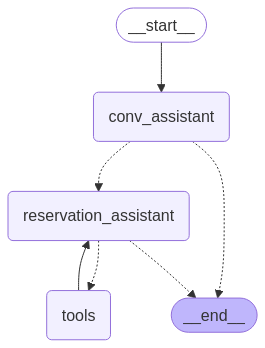

In [12]:
# Draw the graph
from IPython.display import Image, display
png = react_graph_with_memory.get_graph().draw_mermaid_png()
display(Image(png))

In [ ]:
from langchain_core.messages import HumanMessage

thread_id = 42

# let's put everything in a chat format

def chat_with_agent(react_graph_with_memory, thread_id):
  """
  Chat with the agent.

  Args:
    react_graph_with_memory (): The graph with the agent.
    thread_id (int): The ID of the thread.
  """
  while True:
      user_input = input("You: ")
      if user_input.lower() in ["quit", "exit"]:
          break

      events = react_graph_with_memory.stream(
          input={"messages": [HumanMessage(content=user_input)]},
          config={"thread_id": thread_id},
          stream_mode="values",
      )

      for event in events:
          event["messages"][-1].pretty_print()
          message_content = event["messages"][-1].content
          if "Answer:" in message_content:
              final_answer = message_content.split("Answer:", 1)[1].strip()
              print(f"Agent: {final_answer}")

chat_with_agent(react_graph_with_memory, thread_id)

================================ Human Message =================================

Hey, I want to book a romm in your hotel
================================== Ai Message ==================================

I’d be happy to help you with that! Could you please provide me with the room type you’re interested in and the dates you would like to book?
================================ Human Message =================================

Family Suite, from 22nd of April 2025 to 26th of April
================================== Ai Message ==================================

Thank you for the information! I will forward your request to our reservation assistant to help you with the booking. Please hold on for a moment. 

Connecting you now with reservation_assistant.
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (call_kiMIHmxEWiLtQrunkezEu71f)
 Call ID: call_kiMIHmxEWiLtQrunkezEu71f
  Args:
    query: SELECT room_number FROM rooms WHERE roo